In [ ]:
"""
a Google Colab notebook to test the VGG16 neural network as implemented here:
https://github.com/saikat15010/Brain-Tumor-Detection/blob/main/VGG16_on_Harvard_Medical_Dataset.ipynb
Code in this notebook is copied as closely from the source as possible, except for comments and changes
to the file directory path due to issues specific on my end.
"""

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
image_size = [256,256]
# current dir for colab appears to be in the /content folder
data_path = '../gdrive/MyDrive/healthcare research data/Harvard Medical Dataset2'

In [ ]:
print(image_size+[3])

[512, 512, 3]


In [ ]:
conv = VGG16(input_shape=image_size+[3], weights='imagenet', include_top=False)
conv.trainable=False # see comments below
conv.output

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
x = conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
x=  Dropout(.2)(x)
pred = Dense(2,activation='softmax')(x)
model = Model(inputs=conv.input, outputs=pred)
# The source material has only 2,100,738 trainables and 14,714,688 non-trainables.
# I am unable to replicate it here.
# Coincidence: only the stuff after GlobalAvgPooling adds up to the trainables count.
# Attempting to set the conv to not-trainable.
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2)

train_generator=train_datagen.flow_from_directory(data_path,
                                                  target_size=(256,256),
                                                  color_mode='rgb',
                                                  shuffle=False,
                                                  subset='training',
                                                  batch_size=10,
                                                  class_mode='categorical')
val_generator = train_datagen.flow_from_directory(data_path,
                                                  target_size=(256,256),
                                                  color_mode='rgb',
                                                  shuffle=False,
                                                  subset='validation',
                                                  batch_size=10,
                                                  class_mode='categorical')

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
! ls ../gdrive/MyDrive/"healthcare research data"

 Brain_MRI2  'Harvard Medical Dataset2'


In [ ]:
print(train_generator.n)
print(train_generator.batch_size)
print(242//32)
print(val_generator.n)
print(val_generator.batch_size)

122
10
7
30
10


In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
# After setting conv to non-trainable,
# the model started to get work done.
# Accuracy reached 1.0.
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train,
                              epochs=40,
                              verbose=1,
                              validation_data=val_generator)

Epoch 1/40
12/12 [==============================] - 6s 310ms/step - loss: 1.4180 - accuracy: 0.3571 - val_loss: 0.6920 - val_accuracy: 0.5333
Epoch 2/40
12/12 [==============================] - 3s 239ms/step - loss: 0.8284 - accuracy: 0.4667 - val_loss: 0.6953 - val_accuracy: 0.4667
Epoch 3/40
12/12 [==============================] - 3s 229ms/step - loss: 0.7401 - accuracy: 0.3036 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 4/40
12/12 [==============================] - 4s 351ms/step - loss: 0.7357 - accuracy: 0.4911 - val_loss: 0.6837 - val_accuracy: 0.9000
Epoch 5/40
12/12 [==============================] - 3s 230ms/step - loss: 0.7053 - accuracy: 0.4107 - val_loss: 0.6773 - val_accuracy: 0.5667
Epoch 6/40
12/12 [==============================] - 3s 244ms/step - loss: 0.6999 - accuracy: 0.5089 - val_loss: 0.6780 - val_accuracy: 0.4667
Epoch 7/40
12/12 [==============================] - 3s 238ms/step - loss: 0.6889 - accuracy: 0.4911 - val_loss: 0.6299 - val_accuracy: 0.9333
Epoch 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# for making a confusion matrix and a classification report
Y_pred = model.predict_generator(val_generator, val_generator.n // val_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
print(val_generator.classes)

print('Confusion Matrix')
"""
The conf matrix ranges from:
16 0
1 13
to
16 0
3 11
changing after every time the cell above is run.
Though as of the last 10 or so runs it has settled on the better conf matrix.
"""
print(confusion_matrix(val_generator.classes, y_pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Confusion Matrix
[[16  0]
 [ 1 13]]


In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy Score :',accuracy_score(val_generator.classes,y_pred))
print('Report : ')
print(classification_report(val_generator.classes,y_pred))
# Almost perfect, but as the conf matrix suggests it isn't.

Accuracy Score : 0.9666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.93      0.96        14

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(val_generator.classes, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.9642857142857143

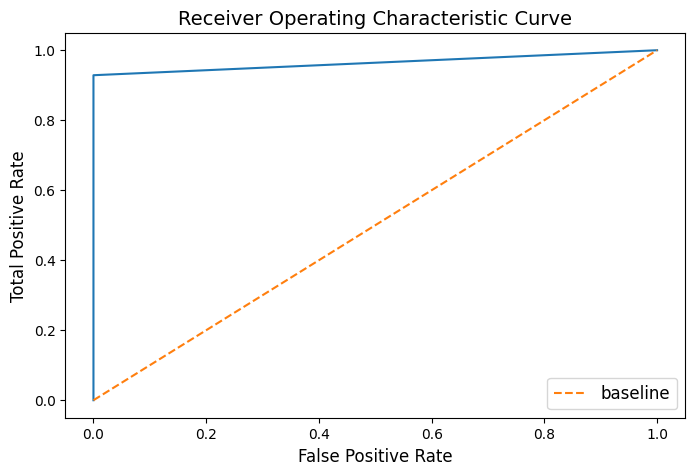

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);
# As you can see, our attempt didn't quite get to perfection.

In [ ]:
"""
Now to test the CNN on the Harvard data set.
Source:
https://github.com/saikat15010/Brain-Tumor-Detection/blob/main/CNN%20on%20Harvard%20Medical%20Dataset.ipynb
"""
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
! pip install keras-layer-normalization

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
# Keras must have updated their setup at some point
import numpy as np
tf.keras.backend.clear_session()

In [ ]:
#Initial  BLock of the model
ini_input=keras.Input(shape=(512,512,3),name="image")

x1=layers.Conv2D(64,(22,22),strides=2)(ini_input)
x1=layers.MaxPooling2D((4,4))(x1)
x1=layers.BatchNormalization()(x1)

x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
x2=layers.MaxPooling2D((2,2))(x2)
x2=layers.BatchNormalization()(x2)

x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
x3=layers.MaxPooling2D((2,2))(x3)
x3=layers.BatchNormalization()(x3)

x4=layers.Conv2D(512,(3,3),strides=2,padding="same")(x3)
x4=layers.MaxPooling2D((2,2))(x4)
x4=layers.BatchNormalization()(x4)

x5=layers.GlobalAveragePooling2D()(x4)
x5=layers.Activation("relu")(x5)

x6=layers.Dense(1024,"relu")(x5)
x6=layers.BatchNormalization()(x6)
x7=layers.Dense(512,"relu")(x6)
x7=layers.BatchNormalization()(x7)
x8=layers.Dense(256,"relu")(x7)
x8=layers.BatchNormalization()(x8)
x8=layers.Dropout(.2)(x8)
x9=layers.Dense(2)(x8)
pred=layers.Activation("softmax")(x9)

model=keras.Model(inputs=ini_input,outputs=pred)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 246, 246, 64)      92992     
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 61, 61, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 128)       991360    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0     

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2)

train_generator=train_datagen.flow_from_directory(data_path,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  subset='training',
                                                  batch_size=10,
                                                  class_mode='categorical')
val_generator = train_datagen.flow_from_directory(data_path,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  subset='validation',
                                                  batch_size=10,
                                                  class_mode='categorical')

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
print(train_generator.n)
print(train_generator.batch_size)
print(242//32)

122
10
7


In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
# using fit_generator caused the notebook to crash.
# retrying this portion of work in a new notebook.
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train,
                              epochs=80,
                              verbose=1,
                              validation_data=val_generator)


Epoch 1/80
